In [16]:
# Alle Variablen löschen ohne zu fragen.
# Hierdurch werden Seiteneffekte vermieden.
%reset -f

In [17]:
# Liste der Variablen ausgeben
%whos       

No variables match your requested type.


# Kurze Anmerkung zu Beginn

#### Im folgenden Notebook wird eine Pixel-orientierte Bildoperation beispielhaft gezeigt.

Dabei wird mit zwei geschachtelten for-Schleifen Pixel für Pixel über des Bild iteriert.
Da Python (wie auch Matlab) eine interpretierte Sprache ist, ist dieses Vorgehen sehr (!) ineffizient. 

Da es in den Praktikumsversuchen um das Verständnis der Algorithmen geht, wählen wir trotzdem diesen ineffizienten  Weg, d.h. auf der Basis von for-Schleifen über die Bildpunkte. 

Sehr effizient ist hingegen (besonders unter Python und Matlab), wenn die durchzuführenden Anwendungen auf der Basis von Vektor- und Matrixoperationen arbeiten (z.B. mit der Python-Bibliothek "numpy"). Das ist auch mit maschienennahem Code kaum zu toppen. 

Für Projekte, die eine sehr effiziente Verarbeitung großer Bilddatenmengen erfordern (z.B. Machine-Learning-Projekte), stehen unter Python sehr leistungsfähige Bildverarbeitungsbibliotheken zur Verfügung (skimage, sklearn, opencv, usw.). Diese beinhalten umfangreiche Bildverarbeitungsmethoden.

In [18]:
%matplotlib notebook

# Laden der verwendeten Bibliotheken
from PIL import Image
import   numpy  as np               
import   scipy 
import   matplotlib                 # https://matplotlib.org/3.1.1/tutorials/index.html
import   matplotlib.pyplot as plt   # https://matplotlib.org/tutorials/introductory/pyplot.html
import   sklearn 
import   skimage
from     skimage import data
import   time
from     scipy import signal

## PIL-Images 


#### Folgende Aktionen lassen sich vorteihaft mit PIL-Befehlen durchführen:
- Laden und Speichern von von Bildern
- Bildausschnitte erzeugen
- Bilder skalieren und rotieren (mit verschiedenen Interpolationsverfahren)
- Bilder übereinanderlegen (überblenden)
- Farbtransformation 
- uvm.

Mehr Informationen zu PIL-Images und -methoden findet man unter :
https://pillow.readthedocs.io/en/3.1.x/reference/Image.html

Für die Verarbeitung von Bildern auf Bildpunktebene (Pixelverarbeitung) ist es jedoch günstiger, die PIL-Images in numpy-Arrays umzuwandeln (s.u.).

In [19]:
# Bild laden mit PIL
img = Image.open("shaft.bmp")
#img = Image.open("circle.bmp")
#img = Image.open("boat512.bmp")
#img = Image.open("tasse1.bmp")

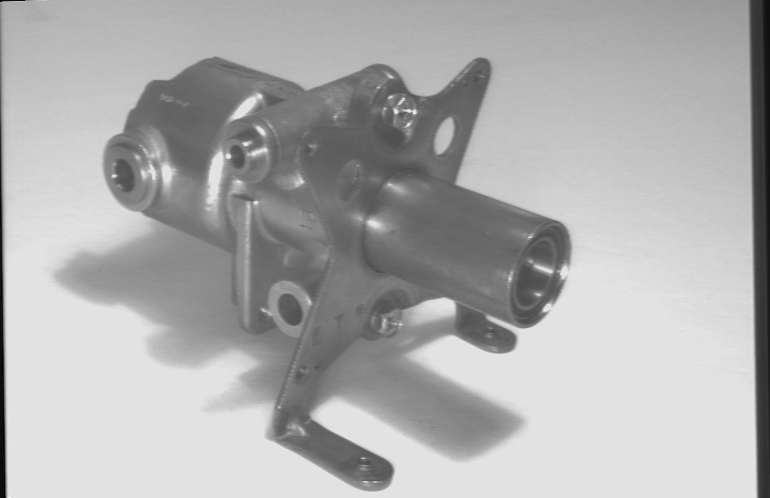

In [20]:
# PIL-Image darstellen
img

## Liste der PIL-Images-Bildtypen

Die PIL-Bibliothek unterstützt viele unterschiedliche Grau- und Farbbild-Datentypen (Modes):

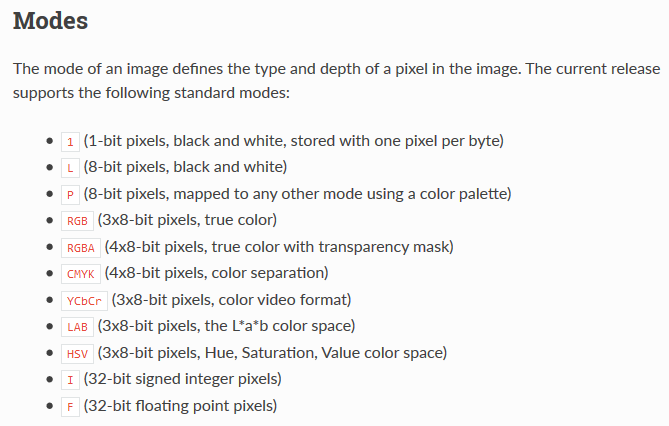

In [21]:
# Informationen über PIL-Image
print('format =', img.format)
print('info   =', img.info)
print()
print('size   =', img.size,)
print('mode   =', img.mode)  # 'L' = 8-bit-unsigned

format = BMP
info   = {'dpi': (72, 72), 'compression': 0}

size   = (770, 498)
mode   = L


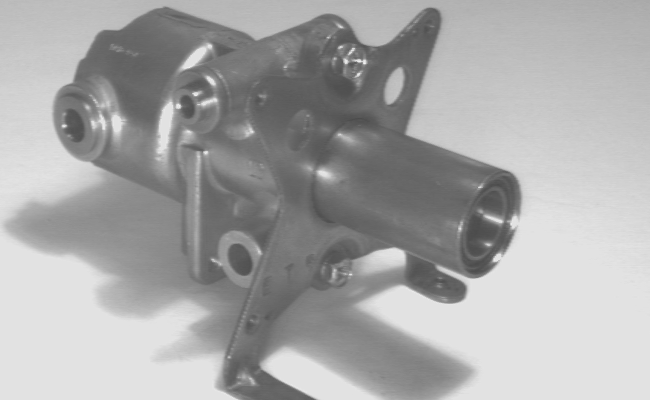

In [22]:
# Beispiel:  Bildausschnitt erzeugen mit PIL-Bild
region = img.crop((50, 50, 700, 450))  # oben links - unten rechts
region

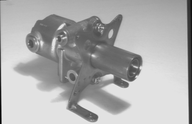

In [23]:
# Beispiel:  Verkleinerung von Bildern
size = (int(img.width/4), int(img.height/4)) # Bildgröße bestimmen und in einem Tupel zusammenfassen
imgsmall = img.resize(size, resample=1)      # Nearest-Neighbour (0), Bilinear (1), Bicubic (2), Lanczos (3)
imgsmall

# numpy : Vektoren, Arrays, lineare Algebra und vieles mehr ...
Die aktuelle Dokumentation findet man unter:
https://numpy.org/doc/1.18/

Der Zugriff auf einzelne Bildmatrix-Elemente ist unter numpy günstiger. 
Daher nun der Wechsel von PIL-Images zu numpy-Arrays.

In [24]:
print('Installierte Numpy-Version = ', np.__version__)

Installierte Numpy-Version =  1.18.1


In [25]:
# PIL-Image in ein numpy-Array umwandeln
img2 = np.array(region)
img2

array([[187, 186, 186, ..., 169, 169, 169],
       [186, 188, 188, ..., 169, 169, 170],
       [186, 187, 187, ..., 168, 168, 170],
       ...,
       [226, 226, 226, ..., 226, 226, 226],
       [226, 226, 226, ..., 226, 226, 226],
       [226, 226, 226, ..., 226, 226, 226]], dtype=uint8)

In [26]:
# Informationen über numpy-Array
print('shape =', img2.shape)
print('type  =', img2.dtype)
print('min   =', img2.min())
print('max   =', img2.max())

shape = (400, 650)
type  = uint8
min   = 75
max   = 242


<IPython.core.display.Javascript object>


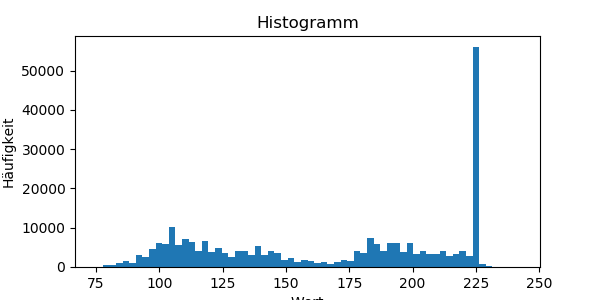

Text(0.5, 1.0, 'Histogramm')

In [27]:
# Histogramm des Bildes anzeigen
plt.figure(figsize = (6,3))

plt.hist(img2.flatten(), bins=64)

plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.title('Histogramm')

In [28]:
# in höheren Datentyp umwandeln  (uint8 --> int), damit Ergebnisse nicht beschnitten werden !

srcpic  = np.copy(img2)      # eine echte Kopie anlegen
srcpic  = srcpic.astype(int) # und in den Datentyp int umwandeln

print('srcpic.dtype     = ', srcpic.dtype)

srcpic.dtype     =  int32


In [29]:
# Selbstgeschriebene Schärfungsfunktion
# ------------------------------------------------------
# Verwendet wird die Faltungsmaske (4-er-Nachbarschaft):
#      -1
#   -1 +5 -1
#      -1
#
# In : int32-Bild
# Out: int32-Bild

def MySharp(src):
    
    # Zielbilder anlegen
    dst = np.copy(src)

    # Größe des Quellbildes bestimmen
    ysize = src.shape[0]
    xsize = src.shape[1]

    print('Bildgröße =', xsize, '/',  ysize)

    src = src.astype(int)
    dst = dst.astype(int)
    
    for y in range(1,ysize-1):
        for x in range(1,xsize-1):
            dst[y][x] = (5*src[y][x] - src[y][x-1] - src[y][x+1] - src[y-1][x] - src[y+1][x])
    return dst

In [30]:
start = time.time()

# Schärfungsoperator aufrufen
mw_img = MySharp(srcpic)

ende   = time.time()
print('Runtime   = {:5.3f}s'.format(ende-start))

print('dtype     = ', mw_img.dtype)

Bildgröße = 650 / 400
Runtime   = 0.714s
dtype     =  int32


<IPython.core.display.Javascript object>


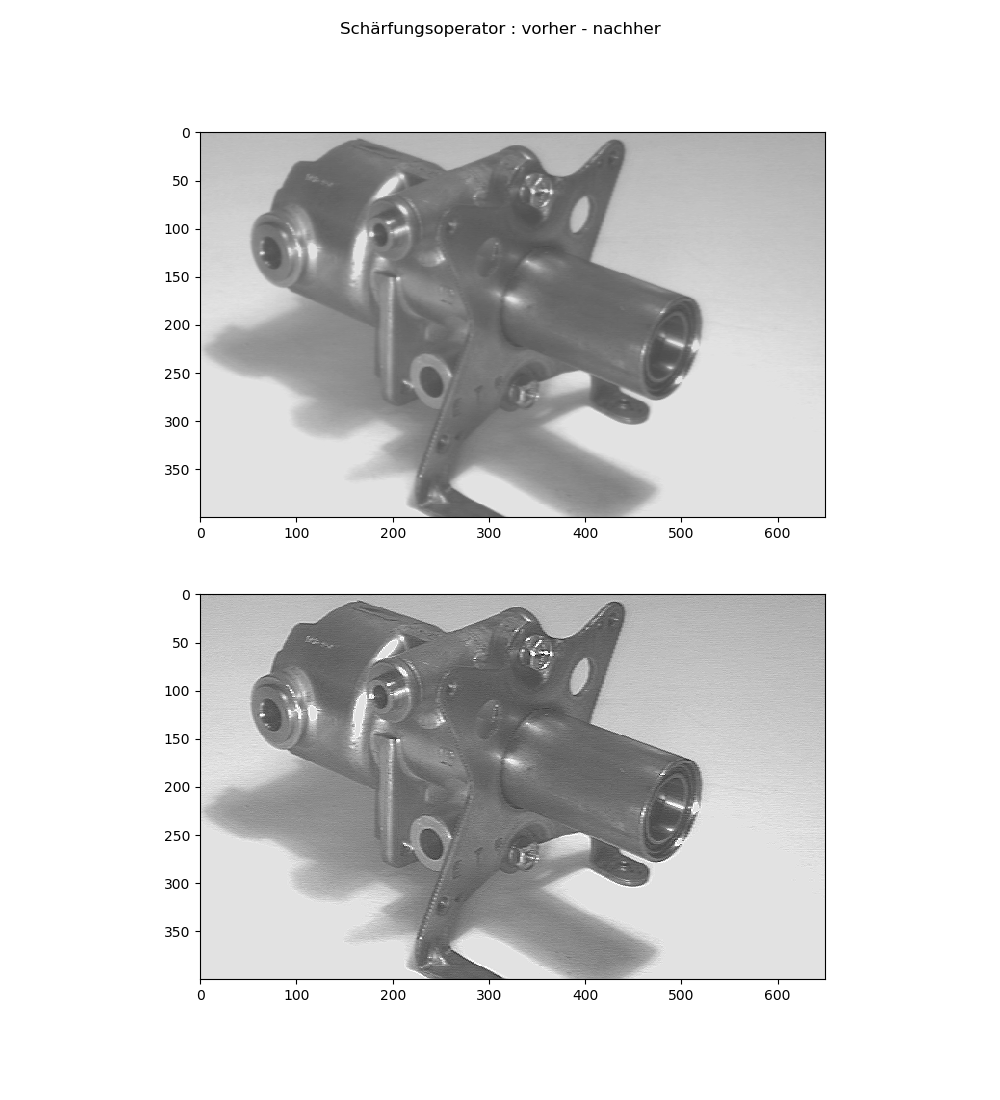

min/max = -13 387
shape   = (400, 650)
dtype   = int32


In [31]:
pic = mw_img;


plt.figure(figsize = (10,11))

plt.subplot(211)
plt.imshow(srcpic, cmap='gray', vmin=0, vmax=255)
plt.subplot(212)
plt.imshow(pic, cmap='gray', vmin=0, vmax=255)
plt.suptitle('Schärfungsoperator : vorher - nachher')
plt.show()

# Informationen zum Bild
print('min/max =', pic.min(), pic.max())
print('shape   =', pic.shape)
print('dtype   =', pic.dtype)

In [32]:
# Zum Vergleich: Laufzeit bei Nutzung der scipy-2d-Faltungsoperation

mask = np.array([[0, -1, 0],
                 [-1, 5, -1],
                 [0, -1, 0]])

start = time.time()
shpic = signal.convolve2d(srcpic, mask)
ende  = time.time()
print('Runtime   = {:5.3f}s'.format(ende-start))

Runtime   = 0.009s


<IPython.core.display.Javascript object>


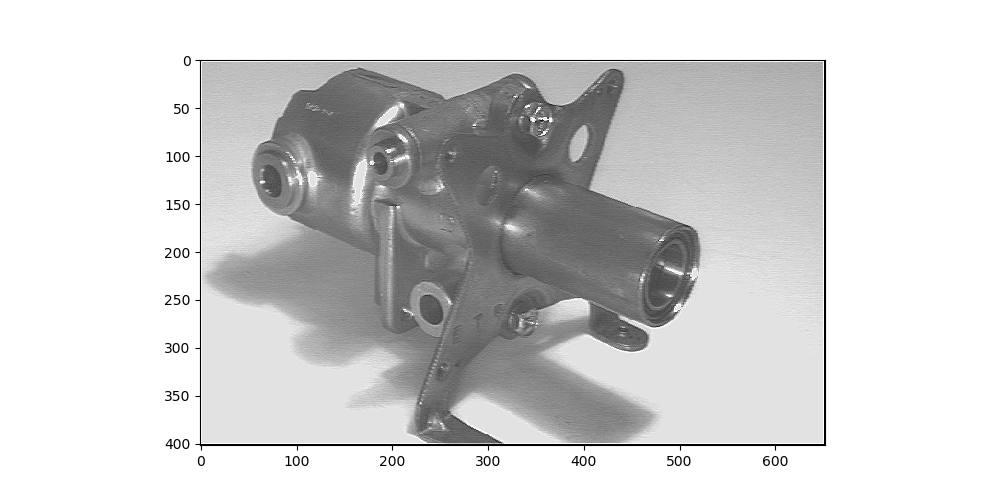

In [34]:
pic = shpic;
plt.figure(figsize = (10,5))
plt.imshow(pic, cmap='gray', vmin=0, vmax=255)

In [103]:
# Anm.:  ca. 50-70 mal schneller

In [105]:
# Liste der Variablen ausgeben
%whos    

Variable     Type            Data/Info
--------------------------------------
Image        module          <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
MySharp      function        <function MySharp at 0x000001769A85C948>
data         module          <module 'skimage.data' fr<...>mage\\data\\__init__.py'>
ende         float           1585076762.4701078
img          BmpImageFile    <PIL.BmpImagePlugin.BmpIm<...>640x480 at 0x17698D7A148>
img2         ndarray         400x650: 260000 elems, type `uint8`, 260000 bytes (253.90625 kb)
imgsmall     Image           <PIL.Image.Image image mo<...>160x120 at 0x1769A15B948>
mask         ndarray         3x3: 9 elems, type `int32`, 36 bytes
matplotlib   module          <module 'matplotlib' from<...>matplotlib\\__init__.py'>
mw_img       ndarray         400x650: 260000 elems, type `int32`, 1040000 bytes (1015.625 kb)
np           module          <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
pic          ndarray         402x652: 26